# Zernike Fitting

<a target="_blank" href="https://colab.research.google.com/github/chromatix-team/chromatix/blob/main/docs/examples/zernike_fitting.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In this notebook we will fit Zernike coefficients to measured point spread functions. 

In [ ]:
# If in Colab, install Chromatix. Don't forget to select a GPU!
!pip install --upgrade pip
!pip install git+https://github.com/chromatix-team/chromatix.git

In [1]:
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
from jax import random
from jaxtyping import Array, PRNGKeyArray

from chromatix.functional import ff_lens, objective_point_source, phase_change
from chromatix.ops import shot_noise
from chromatix.utils import zernike_aberrations

key = random.PRNGKey(42)

## Constructing the forward model 

First we need to model how Zernike coefficients affect the PSFs. This is done by calculating the Zernike aberrations from the coefficients (given as ANSI indices).

In [2]:
class ZernikePSF(eqx.Module):
    coefficients: Array  # This is what we want to optimize!
    ansi_indices: Array = eqx.field(
        static=True, default_factory=lambda: np.arange(1, 11)
    )
    camera_shape: tuple[int, int] = eqx.field(static=True, default=(256, 256))
    camera_pixel_pitch: float = eqx.field(static=True, default=0.125)
    f: float = eqx.field(static=True, default=100.0)
    NA: float = eqx.field(static=True, default=0.8)
    n: float = eqx.field(static=True, default=1.33)
    wavelength: float = eqx.field(static=True, default=0.532)
    upsample: int = eqx.field(static=True, default=4)
    pad: int = eqx.field(static=True, default=128)

    def __call__(self, key: PRNGKeyArray | None = None) -> Array:
        shape = tuple(np.array(self.camera_shape) * self.upsample + self.pad)
        spacing = (
            self.upsample
            * self.f
            * self.wavelength
            / (self.n * shape[0] * self.camera_pixel_pitch)
        )
        field = objective_point_source(
            shape, spacing, self.wavelength, 0.0, self.f, self.n, self.NA, power=1e3
        )
        aberrations = zernike_aberrations(
            shape,
            spacing,
            self.wavelength,
            self.n,
            self.f,
            self.NA,
            self.ansi_indices,
            self.coefficients,
            normalize=False,
        )
        field = phase_change(field, aberrations)
        field = ff_lens(field, self.f, self.n)
        image = field.intensity
        if key is not None:
            image = shot_noise(key, image)
        return image

Now, using the ZernikePSF forward model, let's generate a "measured" PSF for some "unknown" coefficients that we will ultimately like to learn.

/tmp/ipykernel_2897489/648983639.py:2: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = ZernikePSF(jnp.zeros((10,)))
/tmp/ipykernel_2897489/648983639.py:6: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  true_model = ZernikePSF(coefficients_truth)


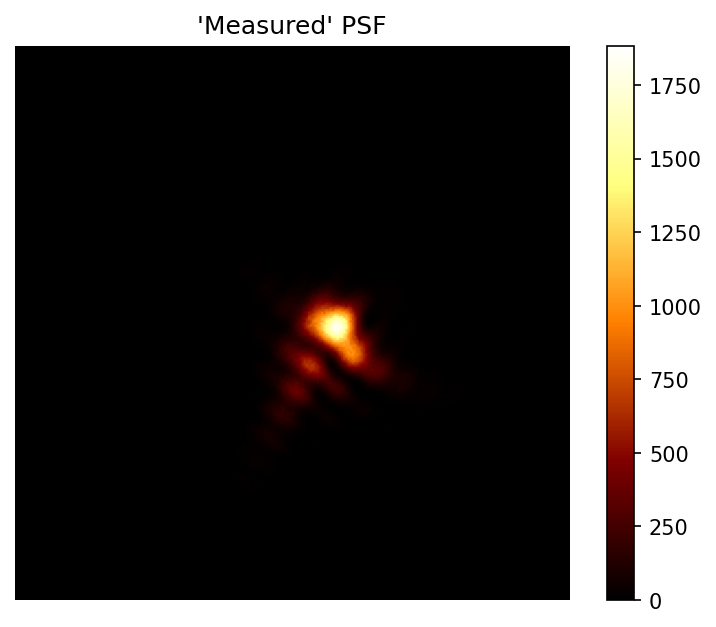

In [3]:
# Initialize model
model = ZernikePSF(jnp.zeros((10,)))

# Specify "ground truth" parameters for Zernike coefficients
coefficients_truth = jnp.array([2.0, 5.0, 3.0, 0, 1, 0, 1, 0, 1, 0]) / (
    2 * jnp.pi / model.wavelength
)
true_model = ZernikePSF(coefficients_truth)

# Generating data
psf_truth = true_model(key=key)

crop = 450
plt.figure(dpi=150)
plt.imshow(psf_truth.squeeze()[crop:-crop, crop:-crop], cmap="afmhot")
plt.colorbar()
plt.title("'Measured' PSF")
plt.axis("off")
plt.show()

## Learning Zernike Coefficients 

Now that we have our target PSF, we will learn its underlying Zernike coefficients by optimizing through the forward model. First let's define a few functions needed for the training.

In [4]:
# This loss function will be our metric for measuring how close our predicted PSF is to the measured PSF. For now we
# use mean squared error.
def loss_fn(model, data):
    psf_estimate = model()
    loss = jnp.mean((psf_estimate - data) ** 2) / jnp.mean(data**2)
    return loss, {"loss": loss}


# Creating the optimizer
optimizer = optax.adam(0.001)
opt_state = optimizer.init(model)


# Defining the function that updates the parameters
@jax.jit
def update(model, opt_state, data):
    grads, metrics = jax.grad(loss_fn, has_aux=True)(model, data)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = optax.apply_updates(model, updates)
    return model, metrics

Now its time to learn! We using our forward model and the optimization parameters/functions specified above we will
learn the coefficients that correspond to a PSF that best matches our measured PSF. First we display our initial guess.

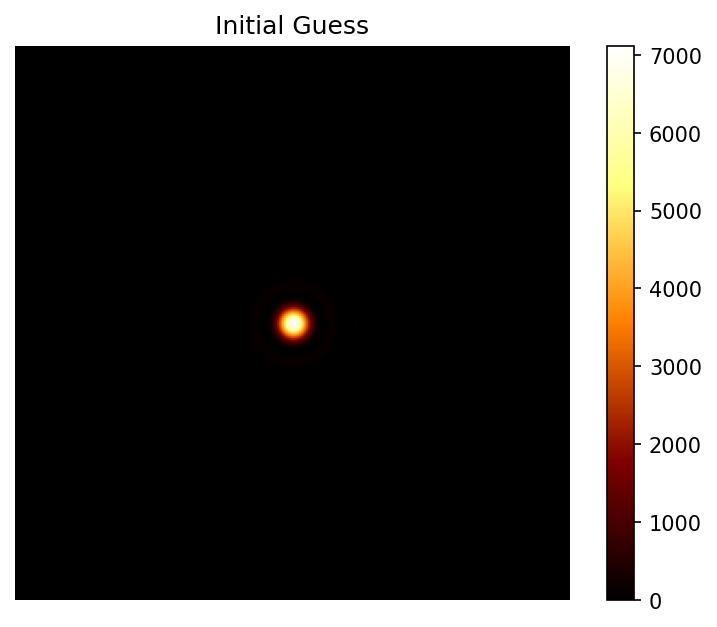

In [5]:
psf_init = model()

plt.figure(dpi=150)
plt.imshow(psf_init[crop:-crop, crop:-crop], cmap="afmhot")
plt.colorbar()
plt.title("Initial Guess")
plt.axis("off")
plt.show()

Below is the optimization loop:

In [6]:
%%time
# Now we optimize
max_iterations = 1000
print_every = 100
history = []
for iteration in range(max_iterations):
    model, metrics = update(model, opt_state, psf_truth)
    history.append(metrics["loss"])
    if iteration % print_every == 0:
        print(iteration, metrics)

0 {'loss': Array(5.619491, dtype=float32)}
100 {'loss': Array(1.3853462, dtype=float32)}
200 {'loss': Array(0.33181638, dtype=float32)}
300 {'loss': Array(0.12421825, dtype=float32)}
400 {'loss': Array(0.06808487, dtype=float32)}
500 {'loss': Array(0.00174069, dtype=float32)}
600 {'loss': Array(0.00174069, dtype=float32)}
700 {'loss': Array(0.00174069, dtype=float32)}
800 {'loss': Array(0.00174069, dtype=float32)}
900 {'loss': Array(0.00174069, dtype=float32)}
CPU times: user 17.1 s, sys: 260 ms, total: 17.4 s
Wall time: 17.7 s


Text(0.5, 0, 'iteration')

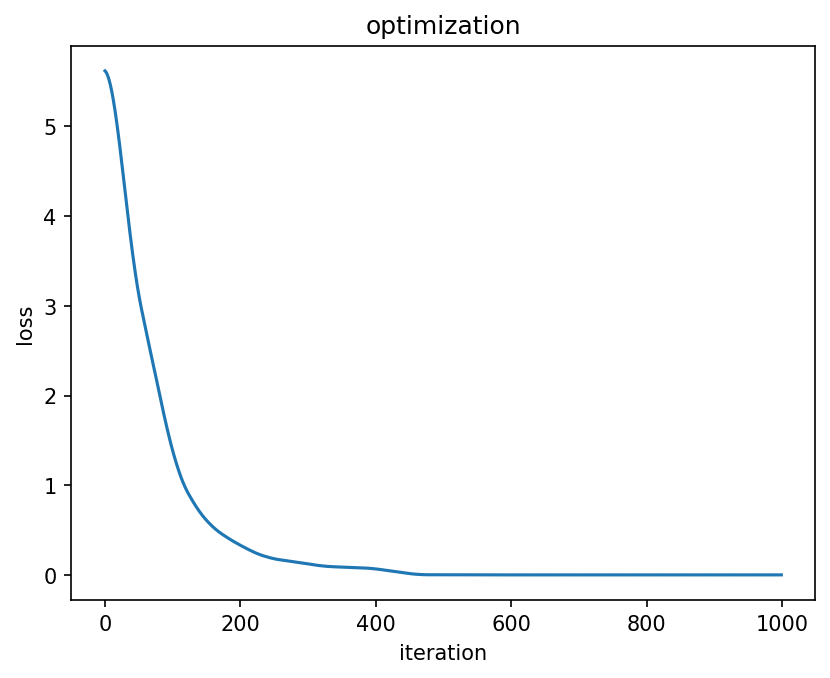

In [7]:
fig = plt.figure(dpi=150)
ax = fig.gca()
ax.plot(history)
ax.set_title("optimization")
ax.set_ylabel("loss")
ax.set_xlabel("iteration")

Let's see how well we did!

Estimated coefficients: [ 0.16599864  0.42599547  0.25199768  0.00199996  0.07999928  0.00200003
  0.08599944 -0.00200005  0.08599587  0.00200054]
Coefficients error: [1.1170476e-05 6.9871248e-06 4.0546806e-06 3.9998254e-06 2.1819702e-05
 4.0001373e-06 1.7662735e-06 4.0002146e-06 1.7567804e-06 4.0021482e-06]
Mean coefficients error: 6.355736e-06


Text(0, 0.5, 'Estimation error')

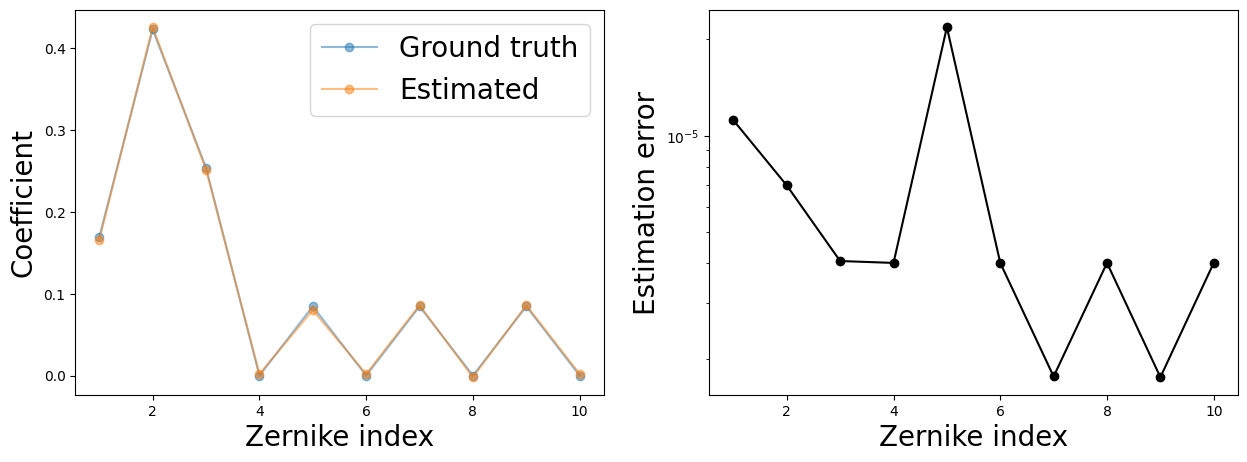

In [8]:
# Our final predicted coefficients
coefficients_estimated = model.coefficients
print("Estimated coefficients:", coefficients_estimated)

coefficients_error = (coefficients_estimated - coefficients_truth) ** 2
print("Coefficients error:", coefficients_error)

mean_coefficients_error = jnp.mean((coefficients_estimated - coefficients_truth) ** 2)
print("Mean coefficients error:", mean_coefficients_error)

# Plots of ground truth, estimates and errors
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fontsize = 20

ax[0].plot(
    model.ansi_indices, coefficients_truth, "-o", label="Ground truth", alpha=0.5
)
ax[0].plot(
    model.ansi_indices, coefficients_estimated, "-o", label="Estimated", alpha=0.5
)
ax[0].set_xlabel("Zernike index", fontsize=fontsize)
ax[0].set_ylabel("Coefficient", fontsize=fontsize)
ax[0].legend(fontsize=fontsize)

ax[1].semilogy(model.ansi_indices, coefficients_error, "k-o")
ax[1].set_xlabel("Zernike index", fontsize=fontsize)
ax[1].set_ylabel("Estimation error", fontsize=fontsize)

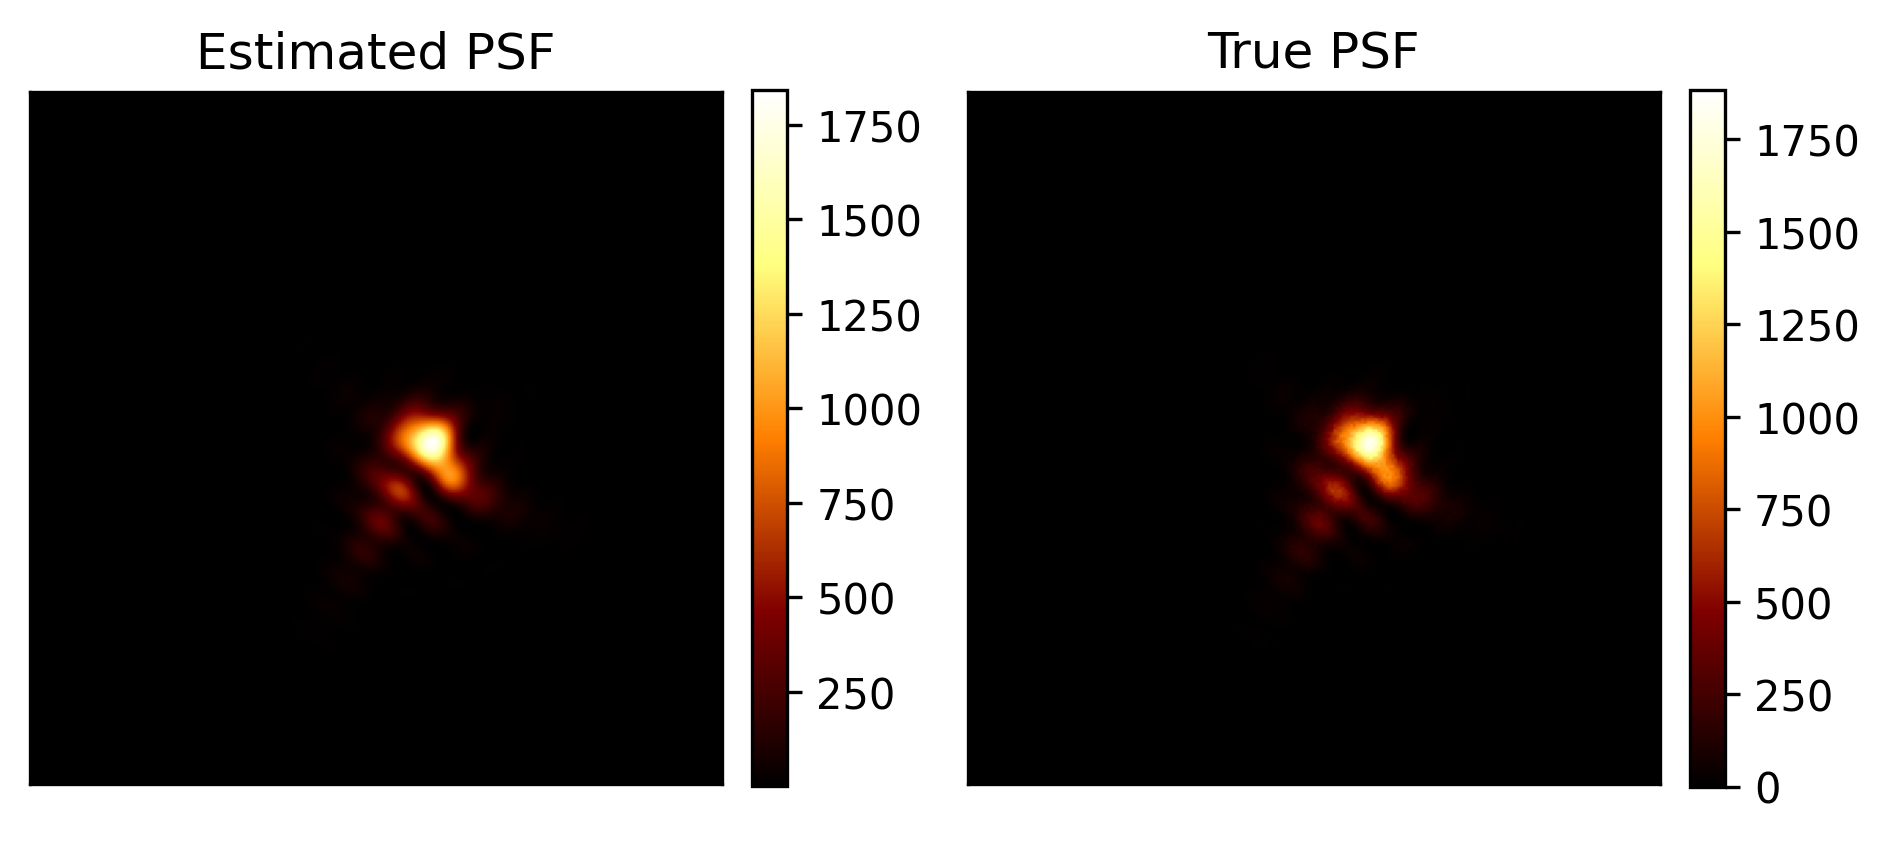

In [9]:
psf_estimated = model()

fig, ax = plt.subplots(1, 2, dpi=300)
m = ax[0].imshow(psf_estimated[crop:-crop, crop:-crop], cmap="afmhot")
plt.colorbar(m, fraction=0.046, pad=0.04)
ax[0].title.set_text("Estimated PSF")
m = ax[1].imshow(psf_truth[crop:-crop, crop:-crop], cmap="afmhot")
plt.colorbar(m, fraction=0.046, pad=0.04)
ax[1].title.set_text("True PSF")
for ax in ax:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()